# 如何在Colab上使用OpenVINO運行姿態估測

作者： Jack OmniXRI, 2023/5/16 

**註：本程式主要用於 human-pose-estimation-0001 姿態估測模型，共18個關鍵點，輸入為 [B, C, H, W] （1, 3, 256, 456)，輸出為 Mconv7_stage2_L1（1, 38, 32, 57）及Mconv7_stage2_L2（1, 19, 32, 57）， 其它模型則由於 output layer 定義不同暫無法使用。**


# 1.安裝OpenVINO

更新pip並安裝OpenVINO開發者最新版本(2022.3)  
如需指定特殊框架[extras]，如onnx, caffe, tensorflow, tensorflow2, mxnet, kaldi, pytorch等，可自行修改指令，如下範例：  
pip install openvino-dev[onnx,pytorch,tensorflow2]  

註：安裝後會出部份紅字錯誤訊息，如下所示  
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 1.3.5 which is incompatible.

主要是因Colab要求的套件版本和OpenVINO安裝的不同，如沒有使用到這些模組，可暫時忽略這項錯誤，繼續執行下面範例。

In [1]:
import time # 引入時間模組

start = time.time() # 開始計算安裝時間

!python -m pip install --upgrade pip #更新 pip
!pip install openvino-dev # 開始安裝 OpenVINO開發者版最新版本

end = time.time() # 記錄結束時間
print("執行時間：%f 秒" % (end - start)) # 輸出時間計算結果

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 13.7 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2384 sha256=4c3db48f97f5afe5c782493b6512e0c86ad3a48a5d2ea00cee363ee8891b3ab2
  Stored in directory: /root/.cache/pip/wheels/12/51/c6/a1e751db88203e11c6d9ffe4683ca3d8c14b1479639bec1006
Successfully built jstyleson
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-

列出已安裝套件包（可略過）

In [2]:
#!pip list

# 2.下載姿態估測模型及測試用影片
使用 open model zoo tools 進行下載及轉換模型，若為Intel Pre-Trained Model則不需執行轉換。  

* human-pose-estimation-0001  

更完整模型介紹：https://docs.openvino.ai/latest/omz_models_model_human_pose_estimation_0001.html  

測試影片來源：https://github.com/intel-iot-devkit/sample-videos/blob/master/store-aisle-detection.mp4

In [3]:
# 使用Open Model Tools下載模型
!omz_downloader --name  human-pose-estimation-0001
!omz_converter --name  human-pose-estimation-0001

################|| Downloading human-pose-estimation-0001 ||################

========== Downloading /content/intel/human-pose-estimation-0001/FP32/human-pose-estimation-0001.xml
... 100%, 148 KB, 384 KB/s, 0 seconds passed

========== Downloading /content/intel/human-pose-estimation-0001/FP32/human-pose-estimation-0001.bin
... 100%, 16010 KB, 11907 KB/s, 1 seconds passed

========== Downloading /content/intel/human-pose-estimation-0001/FP16/human-pose-estimation-0001.xml
... 100%, 213 KB, 542 KB/s, 0 seconds passed

========== Downloading /content/intel/human-pose-estimation-0001/FP16/human-pose-estimation-0001.bin
... 100%, 8005 KB, 7258 KB/s, 1 seconds passed

========== Skipping human-pose-estimation-0001 (no conversions defined)



In [4]:
# 下載所需測試影片檔及相關函式庫
!wget -N https://raw.githubusercontent.com/intel-iot-devkit/sample-videos/master/store-aisle-detection.mp4
!wget -N https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py
!wget -N https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/402-pose-estimation-webcam/decoder.py

--2023-05-16 20:10:38--  https://raw.githubusercontent.com/intel-iot-devkit/sample-videos/master/store-aisle-detection.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9214573 (8.8M) [application/octet-stream]
Saving to: ‘store-aisle-detection.mp4’

store-aisle-detecti 100%[===================>]   8.79M  --.-KB/s    in 0.07s   

Last-modified header missing -- time-stamps turned off.
2023-05-16 20:10:39 (126 MB/s) - ‘store-aisle-detection.mp4’ saved [9214573/9214573]

--2023-05-16 20:10:39--  https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.c

# 3. 姿態估測範例

以下範例參考 OpenVINO Notebooks 
402-pose-estimation.ipynb 修改而得。  
https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/402-pose-estimation-webcam/402-pose-estimation.ipynb

## 3.1 引入必要函式庫

In [5]:
import collections
import sys
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
from openvino.runtime import Core

from decoder import OpenPoseDecoder # 來自 decoder.py
import notebook_utils as utils # 來自 notebook_utils.py

## 3.2 載入及編譯模型
載入及編譯模型並定義輸入及輸出結構。  
註：由於Google Colab只提供Intel Xeon CPU，所以device_name只能設為CPU。

In [6]:
ie_core = Core()
model = ie_core.read_model(model="intel/human-pose-estimation-0001/FP16/human-pose-estimation-0001.xml")
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

input_layer = compiled_model.input(0)
output_layers = compiled_model.outputs
height, width = list(input_layer.shape)[2:]

檢視輸入及輸出層名稱（可略）

In [7]:
input_layer.any_name, [o.any_name for o in output_layers]

('data', ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

## 3.3 準備相關函式

宣告 OpenPose偵測器物件

In [8]:
decoder = OpenPoseDecoder()

定義 2D 池化、非最大值抑制及取得結果姿態函式

In [9]:
# 2D pooling in numpy (from: https://stackoverflow.com/a/54966908/1624463)
def pool2d(A, kernel_size, stride, padding, pool_mode="max"):
    """
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    """
    # Padding
    A = np.pad(A, padding, mode="constant")

    # Window view of A
    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides
    )
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling.
    if pool_mode == "max":
        return A_w.max(axis=(1, 2)).reshape(output_shape)
    elif pool_mode == "avg":
        return A_w.mean(axis=(1, 2)).reshape(output_shape)


# non maximum suppression
def heatmap_nms(heatmaps, pooled_heatmaps):
    return heatmaps * (heatmaps == pooled_heatmaps)


# Get poses from results.
def process_results(img, pafs, heatmaps):
    # This processing comes from
    # https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/models/open_pose.py
    pooled_heatmaps = np.array(
        [[pool2d(h, kernel_size=3, stride=1, padding=1, pool_mode="max") for h in heatmaps[0]]]
    )
    nms_heatmaps = heatmap_nms(heatmaps, pooled_heatmaps)

    # Decode poses.
    poses, scores = decoder(heatmaps, nms_heatmaps, pafs)
    output_shape = list(compiled_model.output(index=0).partial_shape)
    output_scale = img.shape[1] / output_shape[3].get_length(), img.shape[0] / output_shape[2].get_length()
    # Multiply coordinates by a scaling factor.
    poses[:, :, :2] *= output_scale
    return poses, scores

定義繪製姿態函式及繪圖用色彩、骨架連結關係

In [10]:
colors = ((255, 0, 0), (255, 0, 255), (170, 0, 255), (255, 0, 85), (255, 0, 170), (85, 255, 0),
          (255, 170, 0), (0, 255, 0), (255, 255, 0), (0, 255, 85), (170, 255, 0), (0, 85, 255),
          (0, 255, 170), (0, 0, 255), (0, 255, 255), (85, 0, 255), (0, 170, 255))

default_skeleton = ((15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6), (5, 7),
                    (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6))


def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    if poses.size == 0:
        return img

    img_limbs = np.copy(img)
    for pose in poses:
        points = pose[:, :2].astype(np.int32)
        points_scores = pose[:, 2]
        # Draw joints.
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        # Draw limbs.
        for i, j in skeleton:
            if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
                cv2.line(img_limbs, tuple(points[i]), tuple(points[j]), color=colors[j], thickness=4)
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)
    return img

執行姿態估測函式  

輸入若為數字（如0,1...）表示為攝影機編號，亦可為影片檔案。  
本範例無法直接支援網路攝影機，僅支援影片檔案輸入。

In [11]:
# Main processing function to run pose estimation.
def run_pose_estimation(source=0, flip=False, use_popup=False, skip_first_frames=0):
    pafs_output_key = compiled_model.output("Mconv7_stage2_L1")
    heatmaps_output_key = compiled_model.output("Mconv7_stage2_L2")
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()

        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # Resize the image and change dims to fit neural network input.
            # (see https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001)
            input_img = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            # Create a batch of images (size = 1).
            input_img = input_img.transpose((2,0,1))[np.newaxis, ...]

            # Measure processing time.
            start_time = time.time()
            # Get results.
            results = compiled_model([input_img])
            stop_time = time.time()

            pafs = results[pafs_output_key]
            heatmaps = results[heatmaps_output_key]
            # Get poses from network results.
            poses, scores = process_results(frame, pafs, heatmaps)

            # Draw poses on a frame.
            frame = draw_poses(frame, poses, 0.1)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(frame, f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)", (20, 40),
                        cv2.FONT_HERSHEY_COMPLEX, f_width / 1000, (0, 0, 255), 1, cv2.LINE_AA)

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## 3.4 執行姿態估測推論

輸入影片可直接引用本地端預下載的檔案或直接從網路來源。  
若遇到部份瀏覽器造成畫面閃爍，可設為 use_popup=True 改使用OpenCV imshow()來改善，但在Colab上只能設為Flase。  
若需要跳過前端影格不偵測可設為 skip_first_frame=n 來解決，n為影格數量。  


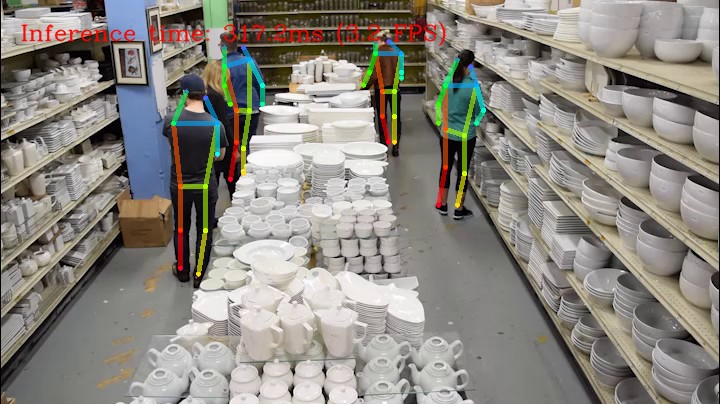

Source ended


In [12]:
video_file = "https://github.com/intel-iot-devkit/sample-videos/blob/master/store-aisle-detection.mp4?raw=true"
#video_file = "store-aisle-detection.mp4"
run_pose_estimation(video_file, flip=False, use_popup=False, skip_first_frames=500)